# How The Threat Landscape Changed in the Pandemic Year 

The purpose of this analysis is to analyze malicious domains submitted to url.abuse[.]ch for the year range of 2019 to 2020. The URL Haus project is an amazing resource used by security practicioners of all kinds to help share and provide insight into malicious urls discovered. The URLhaus project is created and managed by abuse[.]ch, a non profit security reasearcher that manages several additional projects to provide situational awareness and information to aid in internet security against malware.

**The goal of this analysis is to answer the following:**

- What type of malware is more prominant in the year of the pandemic vs the previous year
- Which tld is most seen this year related to malicious threats
- Based on analysis are there any specifc hunts organization can perform to identify traffic going to risky domains.
- Based on analysis are there any detections organizations can put in place to 

**Analysis Breakdown**
- Data Exploration 
- Data Cleaning
- Analysis 
- Reporting and Visualization

In [329]:
import pandas as pd
from csv import reader

#Data Exploration in prep for data cleaning. Converting items in list to quickly asses what the data looks like.


of = open("csv.txt")
rf = reader(of)
data = list(rf)

print(data[:10])


# Data preview of first 10 rows show some header data prior to columns. Will need to skip those rows prior to cleaning.


[['################################################################'], ['# abuse.ch URLhaus Database Dump (CSV)                         #'], ['# Last updated: 2020-12-29 15:44:07 (UTC)                      #'], ['#                                                              #'], ['# Terms Of Use: https://urlhaus.abuse.ch/api/                  #'], ['# For questions please contact urlhaus [at] abuse.ch           #'], ['################################################################'], ['#'], ['# id', 'dateadded', 'url', 'url_status', 'threat', 'tags', 'urlhaus_link', 'reporter'], ['944671', '2020-12-29 15:44:07', 'http://gbimkd.org/wp-includes/mzYzedwYUHNvfwTTy47Ey0o5tKUyazH0oXIs/', 'online', 'malware_download', 'doc,emotet,epoch2', 'https://urlhaus.abuse.ch/url/944671/', 'Cryptolaemus1']]


In [330]:
#Creating a dataframe , but will be skipping first 8 rows of header data.

urls = pd.read_csv("csv.txt",skiprows=8)

columns= urls.columns

print(urls.info(),"\n")



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 931755 entries, 0 to 931754
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   # id          931755 non-null  int64 
 1   dateadded     931755 non-null  object
 2   url           931755 non-null  object
 3   url_status    931755 non-null  object
 4   threat        931698 non-null  object
 5   tags          931755 non-null  object
 6   urlhaus_link  931755 non-null  object
 7   reporter      931755 non-null  object
dtypes: int64(1), object(7)
memory usage: 56.9+ MB
None 



## Data Exploration and Data Cleaning 

- Dataframe created successfully, identifying over 900,000 entries. 
- Datacleaning steps:
 1. Clean up columns to make them easier to work with
 2. Create a new column for year based on dateadded column
 3. Create a new column for month based on date added column
 4. Identify null values
 5. Create a new column for domain bsed or url
 

In [331]:
#loop through column headers to make naming convention more consistent

columns = urls.columns

print("old columns","\n", columns,"\n")

new_columns = []

for c in columns:
    new = c
    if c == "# id":
        new = "id"
        new_columns.append(new)
    elif c =="dateadded":
        new = "date_added"
        new_columns.append(new)
        
    else:
        new_columns.append(new)
        
urls.columns = new_columns


        
print("new columns", "\n",urls.columns,"\n")


print("data preview: \n",urls.head(2))


old columns 
 Index(['# id', 'dateadded', 'url', 'url_status', 'threat', 'tags',
       'urlhaus_link', 'reporter'],
      dtype='object') 

new columns 
 Index(['id', 'date_added', 'url', 'url_status', 'threat', 'tags',
       'urlhaus_link', 'reporter'],
      dtype='object') 

data preview: 
        id           date_added  \
0  944671  2020-12-29 15:44:07   
1  944670  2020-12-29 15:44:05   

                                                 url url_status  \
0  http://gbimkd.org/wp-includes/mzYzedwYUHNvfwTT...     online   
1                       http://116.124.219.2:55737/i     online   

             threat               tags                          urlhaus_link  \
0  malware_download  doc,emotet,epoch2  https://urlhaus.abuse.ch/url/944671/   
1  malware_download     32-bit,arm,elf  https://urlhaus.abuse.ch/url/944670/   

        reporter  
0  Cryptolaemus1  
1       geenensp  


### Parsing date_added column and creating seperate columns for year and month



In [332]:
import datetime 

#converting date_added field to a date dtype,and creating and adding seperate columns to display month and year.

urls["date_added"] = pd.to_datetime(urls["date_added"])

urls["year"] = urls["date_added"].dt.year
urls["month"] = urls["date_added"].dt.strftime("%b")

In [333]:
print(urls["month"].describe())

print(urls["year"].describe())


count     931755
unique        12
top          Sep
freq      202906
Name: month, dtype: object
count    931755.000000
mean       2019.608268
std           0.663945
min        2018.000000
25%        2019.000000
50%        2020.000000
75%        2020.000000
max        2020.000000
Name: year, dtype: float64


### Parsing url column to extract domain

- Data contained in URL column is a mixture of hardcoded IP's and fqdn's
- Will create a new column named domain_request:
 1. For rows where the URL is an IP address, I will indicate "IP" as domain_request
 2. Fore rows where the URL is a fqdn, I will extract only the tld and append in the column.

- I will use the following data cleaning workflow process
 1. Explore the data in the column
 2. Identify patterns and special cases
 3. Remove non applicable characters
 4. Perform any data type conversions necessary
 5. Rename column or create new column if required.
 
I've previewed the strings below and split them based on the forward slash delimeter as that is is a consisten pattern seen in all url request. i.e. http[s]://[hostname/ip]/[path]




In [334]:
print(urls["url"].str.split("/").head(30))

0     [http:, , gbimkd.org, wp-includes, mzYzedwYUHN...
1                     [http:, , 116.124.219.2:55737, i]
2     [http:, , www.ticketshd.com, wp-content, FUfYN...
3     [http:, , thefiercevagabond.com, cgi-bin, Ebob...
4     [http:, , 175.10.51.6:57578, Mozi.a;chmod+777+...
5     [https:, , www.hintup.com.br, wp-content, FE9Q...
6     [http:, , ondigital.one, wp-admin, up9pp9KLyef...
7     [https:, , hdgarden.vn, wp-includes, aZBWciJOr...
8                     [http:, , 115.56.159.28:57022, i]
9     [https:, , www.lixko.com, wp-includes, LEq9VJd, ]
10    [https:, , surfboarddigital.com, carol-stream-...
11             [https:, , srishtiherbs.com, jms, bq8, ]
12         [https:, , unikaryapools.com, wp, ysFiRq1, ]
13                  [http:, , 207.254.247.210:49250, i]
14                   [http:, , 120.57.103.125:55379, i]
15        [https:, , technicalashish.in, wp-admin, M, ]
16    [http:, , thespaceastronauts.com, wp-content, ...
17        [http:, , sanghuangvip.com, wp-admin, 

Based on the preview of data above, the hostname/ip is located at index 2.

- I will extract the domain/ip and place in a newly created column named host

In [335]:
urls["host"]= urls["url"].str.split("/").str[2]

print(urls["host"].head(10))

0               gbimkd.org
1      116.124.219.2:55737
2        www.ticketshd.com
3    thefiercevagabond.com
4        175.10.51.6:57578
5        www.hintup.com.br
6            ondigital.one
7              hdgarden.vn
8      115.56.159.28:57022
9            www.lixko.com
Name: host, dtype: object


Some additional parsing will need to be completed to isolate the TLD.In the following section I will create an addition new column named tld. To accomplish this, I will need to do the following:
- Perform another split on the coloumn, but this split will be based on the "." dellimeter.
- I will append the last item in the index to the tld column
- Some challenges with the data and observations are
 1. some domains have two tld appended i.e. .org.com
 2. request to IP addresses also include port value.
 
- I will create a test dataframe with a subset of data. For fields that contain":", I will indicate that as an IP, for all others, I will simply take the last domain listed.


In [336]:
testdata= urls[["year","host"]].head(10)

#print(testdata)

testdata["tld"] = testdata["host"].str.split(".").str[-1]

#print(testdata)

filter = testdata["tld"].str.contains(":")



testdata.loc[filter,"tld"] = "ip"

print(testdata)






   year                   host  tld
0  2020             gbimkd.org  org
1  2020    116.124.219.2:55737   ip
2  2020      www.ticketshd.com  com
3  2020  thefiercevagabond.com  com
4  2020      175.10.51.6:57578   ip
5  2020      www.hintup.com.br   br
6  2020          ondigital.one  one
7  2020            hdgarden.vn   vn
8  2020    115.56.159.28:57022   ip
9  2020          www.lixko.com  com


Now that I've testing code on a subset of data, will apply to the full DB and previiew the data below

In [337]:
urls["tld"] = urls["host"].str.split(".").str[-1]

filter = urls["tld"].str.contains(":")

urls.loc[filter,"tld"] = "ip"

print(urls[["year","host","tld"]].head(20))

    year                    host  tld
0   2020              gbimkd.org  org
1   2020     116.124.219.2:55737   ip
2   2020       www.ticketshd.com  com
3   2020   thefiercevagabond.com  com
4   2020       175.10.51.6:57578   ip
5   2020       www.hintup.com.br   br
6   2020           ondigital.one  one
7   2020             hdgarden.vn   vn
8   2020     115.56.159.28:57022   ip
9   2020           www.lixko.com  com
10  2020    surfboarddigital.com  com
11  2020        srishtiherbs.com  com
12  2020       unikaryapools.com  com
13  2020   207.254.247.210:49250   ip
14  2020    120.57.103.125:55379   ip
15  2020      technicalashish.in   in
16  2020  thespaceastronauts.com  com
17  2020        sanghuangvip.com  com
18  2020     117.242.211.7:40745   ip
19  2020  nasabatam.bbtbatam.com  com


## Continuing efforts of data exploration and cleaning

- Evaluate null values
1. There isn't a lot of null values within the dataset. Most null values look to be in the threat column which will not tbe used for analysis. 

- Evaluate tags columns
1. My initial thought would be to create a new table by year just containing the tags and their months
2. I will use the split method to look for a "," than add the tag to the new table.

- Final Comments
 - I've created seperate dataframes for each year with it's tags

 - I parsed through the tags column to create a frequency table for each year
 
 - I will then convert each frequency tables to a dataframe(for their year) to aid in sorting.

In [338]:
#print(urls["tld"].value_counts().head(20))

print(urls.columns)

print(urls.info())


Index(['id', 'date_added', 'url', 'url_status', 'threat', 'tags',
       'urlhaus_link', 'reporter', 'year', 'month', 'host', 'tld'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 931755 entries, 0 to 931754
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            931755 non-null  int64         
 1   date_added    931755 non-null  datetime64[ns]
 2   url           931755 non-null  object        
 3   url_status    931755 non-null  object        
 4   threat        931698 non-null  object        
 5   tags          931755 non-null  object        
 6   urlhaus_link  931755 non-null  object        
 7   reporter      931755 non-null  object        
 8   year          931755 non-null  int64         
 9   month         931755 non-null  object        
 10  host          931755 non-null  object        
 11  tld           931755 non-null  object        
dtypes: datetime64[

In [339]:
#2019 Creating a mask to allow me to filter data by year
y19_bool = urls["year"] == 2019
y20_bool = urls["year"] == 2020

#This will filter using boolean mask created to only values of 2019 
t_19 = urls[y19_bool]

# This creates a series of only tag values for 2019
tags_19 = t_19["tags"]

# Empty dict, to house tags. 
tag_freq_19 = {}

#Because tags are in a list of a list, will need to loop through and parse list before adding to dictionary
for t in tags_19:
    split = t.split(",")
    for s in split:
        if s not in tag_freq_19:
            tag_freq_19[s] = 1
        else:
            tag_freq_19[s] += 1
            
print(tag_freq_19)




{'AgentTesla': 1749, 'exe': 52620, 'None': 8980, 'elf': 60786, 'bashlite': 13963, 'gafgyt': 16350, 'zip': 8869, 'mirai': 32173, 'HawkEye': 516, 'iso': 24, 'Loki': 1081, 'img': 3, 'KPOTStealer': 46, 'AZORult': 1015, 'Trickbot': 1344, 'emotet': 45737, 'heodo': 41401, 'PredatorStealer': 427, 'CAN': 1220, 'Nemty': 4, 'Ransomware': 1876, 'downloader': 149, 'orcus': 8, 'CoinMiner': 175, 'doc': 25379, 'predator': 15, 'SystemBC': 29, 'Raccoon Stealer': 1, 'ServHelper': 24, 'Amadey': 25, 'CobaltStrike': 123, 'powershell': 48, 'geofenced': 3706, 'qbot': 174, 'Quakbot': 178, 'USA': 2170, 'vbs': 6327, 'IcedID': 540, 'BrushaLoader': 1214, 'POR': 2, 'vbs-in-zip': 1, 'Gozi': 5677, 'password': 1957, 'CZE': 28, 'ursnif': 912, 'QuasarRAT': 83, 'rat': 696, 'MetaMorfo': 28, 'CHL': 6, 'redirect': 276, 'opendir': 430, 'RTF': 316, 'NanoCore': 799, 'NetWire': 324, 'Hermes': 1, 'Task': 126, 'RaccoonStealer': 52, 'JPN': 39, 'JP': 1, 'Tinba': 134, 'ArkeiStealer': 206, 'RevengeRAT': 25, 'njRAT': 169, 'TrickbotLoa

In [340]:
#This will filter using boolean mask created to only values of 2020
t_20 = urls[y20_bool]

# This creates a series of only tag values for 2020
tags_20 = t_20["tags"]

# Empty dict, to house tags. 
tag_freq_20 = {}

#Because tags are in a list of a list, will need to loop through and parse list before adding to dictionary
for t in tags_20:
    split = t.split(",")
    for s in split:
        if s not in tag_freq_20:
            tag_freq_20[s] = 1
        else:
            tag_freq_20[s] += 1
            
print(tag_freq_20)


{'doc': 27521, 'emotet': 32796, 'epoch2': 15629, '32-bit': 92972, 'arm': 13014, 'elf': 501657, 'heodo': 31264, 'mips': 79660, 'epoch1': 10578, 'exe': 49552, 'Mozi': 384226, 'AsyncRAT': 243, 'x86-32': 317, 'gafgyt': 13217, 'Loki': 893, 'opendir': 15060, 'dofoil': 49, 'Smoke Loader': 226, 'powershell': 115, 'Encoded': 1148, 'epoch3': 6324, 'encrypted': 6062, 'GuLoader': 6383, 'dll': 4975, 'njRAT': 1115, 'bashlite': 10255, 'shellscript': 1622, 'AveMariaRAT': 129, 'AgentTesla': 2518, 'Dridex': 2687, 'msi': 141, 'triumphloader': 3, 'RaccoonStealer': 173, 'None': 14248, 'Trickbot': 16662, 'mirai': 13123, 'TaurusStealer': 11, 'ddos': 844, 'RedLineStealer': 88, 'CoinMiner': 97, 'Tofsee': 2, 'Amadey': 770, 'CobaltStrike': 58, 'SystemBC': 16, 'hfs': 10, 'script': 296, '64-bit': 89, 'x86-64': 87, 'NetWire': 317, 'zip': 19793, 'VoidRAT': 11, 'Xpertrat': 9, 'Gozi': 8459, 'ISFB': 216, 'ursnif': 683, 'bat': 320, 'Quakbot': 14942, 'QuakBOT QBOT': 1, 'Njratgold': 24, 'SilentBuilder': 132, 'DDoS Bot': 1

In [341]:
#New Dataframe of 2019 Tags
tag19 = pd.Series(tag_freq_19).to_frame().reset_index()

tag19.columns = ["tag","count"]

print(tag19)


#New Dataframe of 2020 Tags

tag20 = pd.Series(tag_freq_20).to_frame().reset_index()

tag20.columns = ["tag","count"]

print(tag20)

                  tag  count
0          AgentTesla   1749
1                 exe  52620
2                None   8980
3                 elf  60786
4            bashlite  13963
..                ...    ...
749             jeefo      1
750             Xpert      1
751   passwordstealer      1
752   passwordstealer      1
753               NDL      1

[754 rows x 2 columns]
           tag  count
0          doc  27521
1       emotet  32796
2       epoch2  15629
3       32-bit  92972
4          arm  13014
..         ...    ...
800    #gafgyt      1
801  lunlayloo      1
802       html      1
803        CZE      1
804   DigiCert      2

[805 rows x 2 columns]


## Breakdown of Tags by month

After successfully parsing the tags by year, I wanted to potentially analyze the tags by month for each year. To accomplish this, I used the template I used above to filter by year.

- I created a dataframe that contained tags and the month they were submitted.
- I also created an empty dataframe with columns of tag and month.
 - I iterated through the table that contained the tags and their corresponding month
 - For each row, I segmented the tag field and month field into their own variables
 - For each tag field, I used the split fuction to parse it based on the "," delimeter.
 - I created a new dictionary entry to append the tag and it's coressponding month

In [ ]:
#2019 Creating a mask to allow me to filter data by year
y19_bool = urls["year"] == 2019


#This will filter using boolean mask created to only values of 2019 
t_19 = urls[y19_bool]

# This creates a series of only tag values for 2019
tags_19 = t_19[["tags","month"]]


tags_table_19 = pd.DataFrame(columns = ['tag', 'month']) 

#print(tags_19)
#Because tags are in a list of a list, will need to loop through and parse list before adding to dictionary
for t in tags_19.iterrows():
    tag = t[1][0]
    month = t[1][1]
    
    #print(tag)
    #print(month)
    split = tag.split(",")
    for s in split:
            new_row = {"tag":s,"month":month}
            tags_table_19 = tags_table_19.append(new_row,ignore_index=True)
            
            
        
          
            


#print(tags_table_19.info())
print(tags_table_19.value_counts())

#print(tags_table_19)



In [ ]:
#2020 Creating a mask to allow me to filter data by year
y20_bool = urls["year"] == 2020


#This will filter using boolean mask created to only values of 2020
t_20 = urls[y20_bool]

# This creates a series of only tag values for 2020
tags_20 = t_20[["tags","month"]]



tags_table_20 = pd.DataFrame(columns = ['tag', 'month']) 

#Because tags are in a list of a list, will need to loop through and parse list before adding to dictionary
for t in tags_20.iterrows():
    tag = t[1][0]
    month = t[1][1]
    
    
    split = tag.split(",")
    for s in split:
            new_row = {"tag":s,"month":month}
            tags_table_20 = tags_table_20.append(new_row,ignore_index=True)
            
print(tags_table_20.value_counts())

# Analysis... Yay

If you're still with me by this point, bless your heart. If you've skipped my data exploration and cleaning efforts here's a summary:

1. The URL Haus database was obtained on Dec, 29, 2020. The original dataset that I imported had 7 columns originally:

 0   # id          931755 non-null  int64 
 1   dateadded     931755 non-null  object
 2   url           931755 non-null  object
 3   url_status    931755 non-null  object
 4   threat        931698 non-null  object
 5   tags          931755 non-null  object
 6   urlhaus_link  931755 non-null  object
 7   reporter      931755 non-null  object
 
 2. Cleaning efforts
     -loop through column headers to make naming convention more consistent.
     -Converted date_added field to a date dtype,and created and added seperate columns to display month and year.
     -I created additional new columns titled "host" and "tld". The host column would contain the full malicious domain, and the tld column would contain the tld (i.e. .com,.org) from the parsed the host field.
     -If the url was an IP address(which it often was), I simply placed "IP" in "tld" column. 
 
     -Tackling the tags column! Each entry often had multiple tags, which essentially cauased a list in a list. So I needed to figure out a way to parse this column since the data it contained could provide insight in the attributed malware to the url. 
      - My initial thought would be to create a new table by year just containing the tags and their months
      - I will use the split method to look for a "," than add the tag to the new table.
      - I then created a seperate dataframe for each year with it's tags, but realized I wanted to be a little more granular. 
      - I decided to go one step further and create a table for each year that contained each tags in a seperate line with its corresponding month. 

3. Analysis Questions:

    - What type of malware is more prominant in the year of the pandemic vs the previous year
    - Which tld is most seen this year related to malicious threats
  


 
 

## urls
Data columns (total 12 columns):
     Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            931755 non-null  int64         
 1   date_added    931755 non-null  datetime64[ns]
 2   url           931755 non-null  object        
 3   url_status    931755 non-null  object        
 4   threat        931698 non-null  object        
 5   tags          931755 non-null  object        
 6   urlhaus_link  931755 non-null  object        
 7   reporter      931755 non-null  object        
 8   year          931755 non-null  int64         
 9   month         931755 non-null  object        
 10  host          931755 non-null  object        
 11  tld           931755 non-null  object   

## tag19

    Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tag     754 non-null    object
 1   count   754 non-null    int64 

## tag20

     Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tag     805 non-null    object
 1   count   805 non-null    int64 

## tags_table_19
## tags_table_20



In [273]:
print(tag20.info())
print(urls["host"].head(10))



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 805 entries, 0 to 804
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tag     805 non-null    object
 1   count   805 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 12.7+ KB
None
0               gbimkd.org
1      116.124.219.2:55737
2        www.ticketshd.com
3    thefiercevagabond.com
4        175.10.51.6:57578
5        www.hintup.com.br
6            ondigital.one
7              hdgarden.vn
8      115.56.159.28:57022
9            www.lixko.com
Name: host, dtype: object




            tag  count
3           elf  60786
15       emotet  45737
16        heodo  41401
7         mirai  32173
261     payload  18353
80       epoch2  18099
5        gafgyt  16350
81       epoch1  15454
4      bashlite  13963
36          vbs   6327
41         Gozi   5677
94     Troldesh   5053
78       hajime   4987
32    geofenced   3706
84     Dreambot   3464
76     Formbook   3092
82       epoch3   2765
35          USA   2170
42     password   1957
20   Ransomware   1876


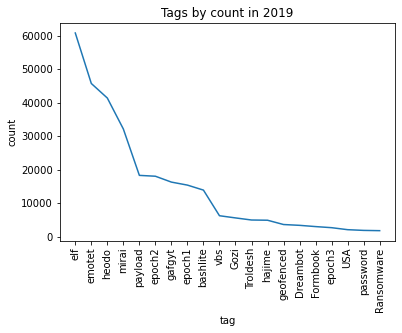

In [326]:
import matplotlib.pyplot as plt

#print(tag19.sort_values(by=["count"],ascending=False).head(20))

print("\n")

#print(tag20.sort_values(by=["count"],ascending=False).head(20))

file_list = ["exe","None","doc","zip","xls"]

file_mask = ~(tag19["tag"].isin(file_list))

tag_19_final = tag19[file_mask].sort_values(by=["count"],ascending=False).head(20)

plt.plot(tag_19_final["tag"],tag_19_final["count"])

plt.xticks(rotation=90)

plt.xlabel("tag")
plt.ylabel("count")
plt.title("Tags by count in 2019")


print(tag19[file_mask].sort_values(by=["count"],ascending=False).head(20))



         tag   count
5        elf  501657
10      Mozi  384226
3     32-bit   92972
7       mips   79660
1     emotet   32796
6      heodo   31264
74    Qakbot   17084
34  Trickbot   16662
2     epoch2   15629
15   opendir   15060
56   Quakbot   14942
13    gafgyt   13217
35     mirai   13123
4        arm   13014
8     epoch1   10578
25  bashlite   10255
52      Gozi    8459
91   ZLoader    7097
22  GuLoader    6383
20    epoch3    6324


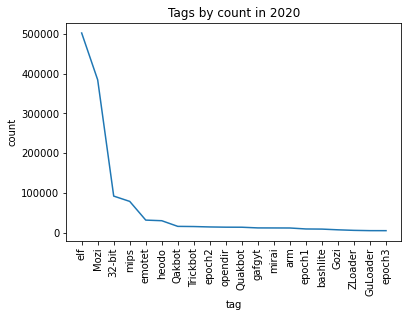

In [327]:
file_mask = ~(tag20["tag"].isin(file_list))

tag_20_final = tag20[file_mask].sort_values(by=["count"],ascending=False).head(20)

plt.plot(tag_20_final["tag"],tag_20_final["count"])

plt.xticks(rotation=90)

plt.xlabel("tag")
plt.ylabel("count")
plt.title("Tags by count in 2020")

print(tag20[file_mask].sort_values(by=["count"],ascending=False).head(20))